In [240]:
import sys
sys.path.append("../")
import wilds
from wilds.common.grouper import CombinatorialGrouper

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import torch
import seaborn as sns
from opacus.accountants.rdp import RDPAccountant


sns.set_style("whitegrid")

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r"""
\usepackage{sansmath}
\sansmath
""" #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

fontsize = 15

In [235]:
def get_sampling_weights(ds_name):
    full_dataset = wilds.get_dataset(
        dataset=ds_name,
        version="1.0",
        root_dir="../data",
        download=True,
        split_scheme="official")

    train_grouper = CombinatorialGrouper(
            dataset=full_dataset,
            groupby_fields=full_dataset._metadata_fields)

    trn_dset = full_dataset.get_subset(
                "train",
                train_grouper=train_grouper,
                frac=1.0,
                subsample_to_minority=False)

    groups, group_counts = train_grouper.metadata_to_group(
                    trn_dset.metadata_array,
                    return_counts=True)
    group_weights = 1 / group_counts
    weights = group_weights[groups]
    weights = weights / weights.sum() * len(trn_dset)
    return weights
    
def get_privacy_spent(sigma, epochs, n_iters, sample_rate):
    accountant = RDPAccountant()
    for _ in range(epochs):
        for _ in range(n_iters):
            accountant.step(noise_multiplier=sigma, sample_rate=sample_rate)
    return accountant.get_privacy_spent(delta=1e-5, alphas=alphas)

def get_sigma_epsilon(ds_name, epochs, sample_rate, sigmas, weighted_sampling=True):
    alphas = [1 + x / 2000.0 for x in range(1, 20000)] + list(range(12, 64))

    if weighted_sampling:
        weight = get_sampling_weights(ds_name).max().item()
    else:
        weight = 1.0

    data = {}
    for sigma in sigmas:
        epsilon, alpha = get_privacy_spent(sigma, epochs, int(1 / sample_rate), sample_rate * weight)
        data[sigma] = epsilon
    return data

In [236]:
def get_res(log_path, col_names):
    df = pd.read_csv(f"{log_path}/train_eval.csv")
    trn_res = df[col_names].values.tolist()[-1]
    df = pd.read_csv(f"{log_path}/test_eval.csv")
    tst_res = df[col_names].values.tolist()[-1]
    return trn_res, tst_res

In [238]:
column_names = [
    ("train", "not blond", "female"),
    ("train", "not blond", "male"),
    ("train", "blond", "female"),
    ("train", "blond", "male"),
    ("test", "not blond", "female"),
    ("test", "not blond", "male"),
    ("test", "blond", "female"),
    ("test", "blond", "male"),
]
order = ['ERM', 'IWERM', 'gDRO', 'DP ERM', 'DP ERM IW']
def key_fn(x):
    ret = []
    for xi in x:
        if xi in order:
            ret.append(order.index(xi))
        else:
            ret.append(0 if xi == "train" else 1)
    return ret

df = pd.DataFrame.from_dict(data).transpose()
df.columns = pd.MultiIndex.from_tuples(column_names)
df = df.stack(0)
df = df.sort_index(axis=0, level=[0, 1], key=key_fn)
print(df.to_latex(float_format="%.2f", multirow=True).replace("llrrrr", "llcccc").replace("{l}", "{c}"))

\begin{tabular}{llcccc}
\toprule
          &      & \multicolumn{2}{c}{blond} & \multicolumn{2}{c}{not blond} \\
          &      & female & male &    female & male \\
\midrule
\multirow{2}{*}{ERM} & train &   1.00 & 0.99 &      1.00 & 1.00 \\
          & test &   0.80 & 0.42 &      0.97 & 1.00 \\
\cline{1-6}
\multirow{2}{*}{IWERM} & train &   0.98 & 0.99 &      0.98 & 0.99 \\
          & test &   0.87 & 0.49 &      0.95 & 0.98 \\
\cline{1-6}
\multirow{2}{*}{DP ERM} & train &   0.80 & 0.41 &      0.96 & 0.99 \\
          & test &   0.74 & 0.29 &      0.98 & 1.00 \\
\cline{1-6}
\multirow{2}{*}{DP ERM IW} & train &   0.94 & 0.96 &      0.88 & 0.90 \\
          & test &   0.92 & 0.85 &      0.91 & 0.92 \\
\bottomrule
\end{tabular}



In [213]:
def get_data(sigmas, log_paths, col_names):
    results = {}
    for sigma, log_path in zip(sigmas, log_paths):
        results.setdefault("sigma", []).append(sigma)

        df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
        train_res = df[["epoch", "acc_avg", "acc_wg"] + col_names].values
        results.setdefault("trn acc", []).append(train_res[-1][1])
        results.setdefault("trn wg acc", []).append(train_res[-1][2])
        disparity = np.max(train_res[-1][4:]) - np.min(train_res[-1][4:])
        results.setdefault("trn disparity", []).append(disparity)

        df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
        res = df[["epoch", "acc_avg", "acc_wg", "epsilon"] + col_names].values.tolist()
        results.setdefault("tst acc", []).append(res[-1][1])
        results.setdefault("tst wg acc", []).append(res[-1][2])
        results.setdefault("epsilon", []).append(res[-1][3])
        disparity = np.max(res[-1][4:]) - np.min(res[-1][4:])
        results.setdefault("tst disparity", []).append(disparity)

    for k, v in results.items():
        results[k] = np.array(v)
    return results

In [214]:
ds_name = "celebA"

col_names = ['acc_y:notblond_male:0', 'acc_y:notblond_male:1', 'acc_y:blond_male:0', 'acc_y:blond_male:1']

sigmas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
log_paths = []
for sigma in sigmas:
    log_paths.append(f"erm-dp_resnet50-lr1e-3-dpsgd_1e-5_{sigma}_1.0_0.0001")
    
data = get_data(sigmas, log_paths, col_names)
df1 = pd.DataFrame.from_dict(data)

sigmas = [0.001, 0.01, 0.1, 1.0]
log_paths = []
for sigma in sigmas:
    log_paths.append(f"weightederm-dp_resnet50-dpsgd_1e-5_{sigma}_1.0_0.0001")
data = get_data(sigmas, log_paths, col_names)
df2 = pd.DataFrame.from_dict(data)

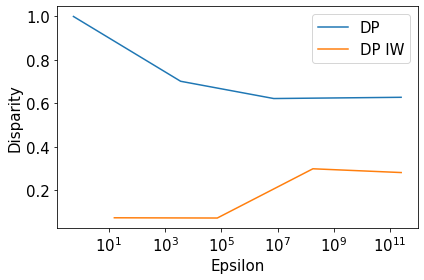

In [217]:
ds_name = "celebA"
epochs = 50
sample_rate = 0.0001

df = pd.merge(df1[['sigma', 'tst disparity']], df2[['sigma', 'tst disparity']], on="sigma")

eps = get_sigma_epsilon(ds_name, epochs, sample_rate, df['sigma'].tolist(), False)
eps = [eps[s] for s in df['sigma'].tolist()]
weps = get_sigma_epsilon(ds_name, epochs, sample_rate, df['sigma'].tolist(), True)
weps = [weps[s] for s in df['sigma'].tolist()]

plt.plot(eps, df['tst disparity_x'].tolist(), label="DP")
plt.plot(weps, df['tst disparity_y'].tolist(), label="DP IW")

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xscale("log")
plt.xlabel("Privacy budget $\epsilon$", fontsize=fontsize)
plt.ylabel("Disparity", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"./figs/disparity_{ds_name}.png")
plt.show()

In [57]:
ds_name = "utkface"

col_names = [
    'acc_y:male_race:White',
    'acc_y:male_race:Black',
    'acc_y:male_race:Asian',
    'acc_y:male_race:Indian',
    'acc_y:male_race:Others',
    'acc_y:female_race:White',
    'acc_y:female_race:Black',
    'acc_y:female_race:Asian',
    'acc_y:female_race:Indian',
    'acc_y:female_race:Others',
]

data = {}
log_path = "../logs/utkface/erm-resnet50/"
data["ERM"] = np.concatenate(get_res(log_path, col_names))
log_path = "../logs/utkface/iwerm-resnet50/"
data["IWERM"] = np.concatenate(get_res(log_path, col_names))
log_path = "../logs/utkface/erm-dp_resnet50-lr1e-3-dpsgd_1e-5_0.1_1.0_0.001/"
data["DP ERM"] = np.concatenate(get_res(log_path, col_names))
log_path = "../logs/utkface/weightederm-dp_resnet50-dpsgd_1e-5_0.1_1.0_0.001/"
data["DP ERM IW"] = np.concatenate(get_res(log_path, col_names))

In [60]:
column_names = []
for i in ["train", "test"]:
    for j in ["male", "female"]:
        for k in ["White", "Black", "Asian", "Indian", "Others"]:
            column_names.append((i, j, k))
            
order = ['ERM', 'IWERM', 'DP ERM', 'DP ERM IW']
def key_fn(x):
    ret = []
    for xi in x:
        if xi in order:
            ret.append(order.index(xi))
        else:
            ret.append(0 if xi == "train" else 1)
    return ret

df = pd.DataFrame.from_dict(data).transpose()
df.columns = pd.MultiIndex.from_tuples(column_names)
df = df.stack(0)
df = df.sort_index(axis=0, level=[0, 1], key=key_fn)
print(df.to_latex(float_format="%.2f", multirow=True).replace("llrrrrrrrrrr", "llccccc|ccccc").repace("{l}", "{c}"))

\begin{tabular}{llcccccccccc}
\toprule
          &      & \multicolumn{5}{l}{female} & \multicolumn{5}{l}{male} \\
          &      &  Asian & Black & Indian & Others & White & Asian & Black & Indian & Others & White \\
\midrule
\multirow{2}{*}{ERM} & train &   1.00 &  1.00 &   1.00 &   0.99 &  1.00 &  1.00 &  1.00 &   1.00 &   0.99 &  1.00 \\
          & test &   0.82 &  0.85 &   0.89 &   0.84 &  0.89 &  0.87 &  0.96 &   0.93 &   0.93 &  0.95 \\
\cline{1-12}
\multirow{2}{*}{IWERM} & train &   1.00 &  1.00 &   1.00 &   0.99 &  1.00 &  1.00 &  1.00 &   1.00 &   0.99 &  1.00 \\
          & test &   0.86 &  0.89 &   0.91 &   0.86 &  0.91 &  0.87 &  0.95 &   0.93 &   0.89 &  0.93 \\
\cline{1-12}
\multirow{2}{*}{DP ERM} & train &   0.87 &  0.89 &   0.94 &   0.90 &  0.90 &  0.86 &  0.96 &   0.92 &   0.85 &  0.91 \\
          & test &   0.87 &  0.90 &   0.93 &   0.96 &  0.93 &  0.76 &  0.92 &   0.88 &   0.77 &  0.88 \\
\cline{1-12}
\multirow{2}{*}{DP ERM IW} & train &   0.87 &  0.90 &   0.93 

In [291]:
ds_name = "utkface"

col_names = [
    'acc_y:male_race:White',
    'acc_y:male_race:Black',
    'acc_y:male_race:Asian',
    'acc_y:male_race:Indian',
    'acc_y:male_race:Others',
    'acc_y:female_race:White',
    'acc_y:female_race:Black',
    'acc_y:female_race:Asian',
    'acc_y:female_race:Indian',
    'acc_y:female_race:Others',
]

sigmas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
log_paths = []
for sigma in sigmas:
    log_paths.append(f"erm-dp_resnet50-lr1e-3-dpsgd_1e-5_{sigma}_1.0_0.001")
data = get_data(sigmas, log_paths, col_names)
df1 = pd.DataFrame.from_dict(data)

sigmas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
log_paths = []
for sigma in sigmas:
    log_paths.append(f"weightederm-dp_resnet50-lr1e-3-dpsgd_1e-5_{sigma}_1.0_0.001")
data = get_data(sigmas, log_paths, col_names)
df2 = pd.DataFrame.from_dict(data)

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


/home/arbiter/.pyenv/versions/3.8.12/envs/spurious_ml/lib/python3.8/site-packages/opacus/accountants/analysis/rdp.py:320: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


0Byte [00:00, ?Byte/s]


../data/UTKFace_v1.0/archive.tar.gz may be corrupted. Please try deleting it and rerunning this command.

Exception:  unknown url type: ''
problem with:  ../data/UTKFace_v1.0/39_1_20170116174525125.jpg.chip.jpg
problem with:  ../data/UTKFace_v1.0/61_1_20170109142408075.jpg.chip.jpg
problem with:  ../data/UTKFace_v1.0/61_1_20170109150557335.jpg.chip.jpg


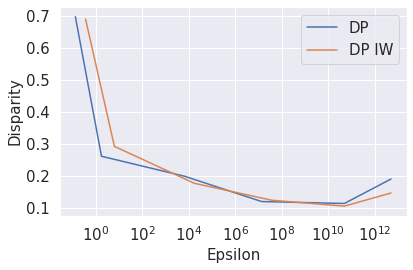

In [292]:
ds_name = "utkface"
epochs = 100
sample_rate = 0.001

df = pd.merge(df1[['sigma', 'tst disparity']], df2[['sigma', 'tst disparity']], on="sigma")

eps = get_sigma_epsilon(ds_name, epochs, sample_rate, df['sigma'].tolist(), False)
eps = [eps[s] for s in df['sigma'].tolist()]
weps = get_sigma_epsilon(ds_name, epochs, sample_rate, df['sigma'].tolist(), True)
weps = [weps[s] for s in df['sigma'].tolist()]

plt.plot(eps, df['tst disparity_x'].tolist(), label="DP")
plt.plot(weps, df['tst disparity_y'].tolist(), label="DP IW")

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xscale("log")
plt.xlabel("Privacy budget $\epsilon$", fontsize=fontsize)
plt.ylabel("Disparity", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"./figs/disparity_{ds_name}.png")
plt.show()

In [148]:
ds_name = "utkface"


You can also download the dataset manually at https://wilds.stanford.edu/downloads.


0Byte [00:00, ?Byte/s]


../data/UTKFace_v1.0/archive.tar.gz may be corrupted. Please try deleting it and rerunning this command.

Exception:  unknown url type: ''
problem with:  ../data/UTKFace_v1.0/39_1_20170116174525125.jpg.chip.jpg
problem with:  ../data/UTKFace_v1.0/61_1_20170109142408075.jpg.chip.jpg
problem with:  ../data/UTKFace_v1.0/61_1_20170109150557335.jpg.chip.jpg


You can also download the dataset manually at https://wilds.stanford.edu/downloads.


0Byte [00:00, ?Byte/s]


../data/UTKFace_v1.0/archive.tar.gz may be corrupted. Please try deleting it and rerunning this command.

Exception:  unknown url type: ''
problem with:  ../data/UTKFace_v1.0/39_1_20170116174525125.jpg.chip.jpg
problem with:  ../data/UTKFace_v1.0/61_1_20170109142408075.jpg.chip.jpg
problem with:  ../data/UTKFace_v1.0/61_1_20170109150557335.jpg.chip.jpg


/home/arbiter/.pyenv/versions/3.8.12/envs/spurious_ml/lib/python3.8/site-packages/opacus/accountants/analysis/rdp.py:320: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


# iNaturalist

In [295]:
ds_name = "inaturalist"

col_names = [
    'acc_y:Actinopterygii',
    'acc_y:Amphibia',
    'acc_y:Animalia',
    'acc_y:Arachnida',
    'acc_y:Aves', 'acc_y:Chromista',
    'acc_y:Fungi', 'acc_y:Insecta',
    'acc_y:Mammalia', 'acc_y:Mollusca',
    'acc_y:Plantae',
    'acc_y:Protozoa',
    'acc_y:Reptilia',
]

sigmas = [0.0001, 0.001, 0.01, 0.1, 1.0]
log_paths = []
for sigma in sigmas:
    log_paths.append(f"erm-dp_resnet18-lr1e-3-dpsgd_1e-5_{sigma}_1.0_0.0001")
data = get_data(sigmas, log_paths, col_names)
df1 = pd.DataFrame.from_dict(data)

sigmas = [0.0001, 0.001, 0.01, 0.1, 1.0]
log_paths = []
for sigma in sigmas:
    print(sigma)
    log_paths.append(f"weightederm-dp_resnet18-dpsgd_1e-5_{sigma}_1.0_0.0001")
data = get_data(sigmas, log_paths, col_names)
df2 = pd.DataFrame.from_dict(data)

0.0001
0.001
0.01
0.1
1.0


You can also download the dataset manually at https://wilds.stanford.edu/downloads.
Using downloaded and verified file: ../data/inaturalist_v1.0/archive.tar.gz
Extracting ../data/inaturalist_v1.0/archive.tar.gz to ../data/inaturalist_v1.0

../data/inaturalist_v1.0/archive.tar.gz may be corrupted. Please try deleting it and rerunning this command.

Exception:  Compressed file ended before the end-of-stream marker was reached


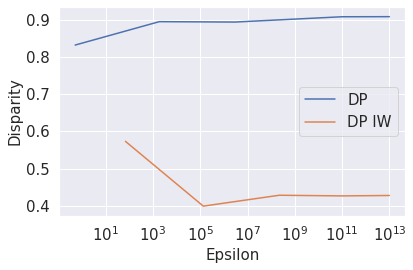

In [296]:
ds_name = "inaturalist"
epochs = 20
sample_rate = 0.0001

df = pd.merge(df1[['sigma', 'tst disparity']], df2[['sigma', 'tst disparity']], on="sigma")

eps = get_sigma_epsilon(ds_name, epochs, sample_rate, df['sigma'].tolist(), False)
eps = [eps[s] for s in df['sigma'].tolist()]
weps = get_sigma_epsilon(ds_name, epochs, sample_rate, df['sigma'].tolist(), True)
weps = [weps[s] for s in df['sigma'].tolist()]

plt.plot(eps, df['tst disparity_x'].tolist(), label="DP")
plt.plot(weps, df['tst disparity_y'].tolist(), label="DP IW")

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xscale("log")
plt.xlabel("Privacy budget $\epsilon$", fontsize=fontsize)
plt.ylabel("Disparity", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"./figs/disparity_{ds_name}.png")
plt.show()